## Common Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json, os, gzip
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_moons, make_circles, make_blobs

Constants

In [2]:
FIGURE_SAVE_PATH: str = "./figures"
TABLE_SAVE_PATH: str = "./table_results"
DATASET_PATH: str = "./datasets"
FILES:list[str] = ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"]

# Sampling length our dataset is too big this makes it more manageable to work with
# 2000 per year is a good representation of our dataset
DEV_MODE:bool = False
SAMPLES_PER_YEAR:int = 250 if DEV_MODE else 2000

### Load the Dataset

In [3]:
# loading data
def read_json_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

def load_all(files=FILES):
    rows = []
    for fp in files:
        for rec in read_json_lines(f"./datasets/{fp}"):
            rows.append(rec)
    return pd.DataFrame(rows)

df = load_all()

as_type = {
    "year": "category",
    "n_citation": np.uint32,
}

df = df.astype(as_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079007 entries, 0 to 3079006
Data columns (total 8 columns):
 #   Column      Dtype   
---  ------      -----   
 0   abstract    object  
 1   authors     object  
 2   n_citation  uint32  
 3   references  object  
 4   title       object  
 5   venue       object  
 6   year        category
 7   id          object  
dtypes: category(1), object(6), uint32(1)
memory usage: 155.6+ MB


In [4]:
df.head(10)

,abstract,authors,n_citation,references,title,venue,year,id
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346
1,This paper describes the design and implementa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,This article applied GARCH model instead AR or...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,NaN,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",0,"[8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...",Development of Remote Monitoring and Control D...,,2011,00338203-9eb3-40c5-9f31-cbac73a519ec
4,NaN,"[Giovanna Guerrini, Isabella Merlo]",2,NaN,Reasonig about Set-Oriented Methods in Object ...,,1998,0040b022-1472-4f70-a753-74832df65266
5,NaN,"[Rafael Álvarez, Leandro Tortosa, José-Francis...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,international conference on computer graphics ...,2009,005ce28f-ed77-4e97-afdc-a296137186a1
6,NaN,"[Jovan Dj. Golic, Guglielmo Morgari]",2,NaN,Vectorial fast correlation attacks.,,2004,00638a94-23bf-4fa6-b5ce-40d799c65da7
7,NaN,"[Guzin Ulutas, Mustafa Ulutas, Vasif V. Nabiyev]",0,"[5626736c-e434-4e2d-8405-54940fab88ab, 8e87e87...",Improved Secret Image Sharing Method By Encodi...,international symposium on computer and inform...,2011,00701b05-684f-45f9-b281-425abfec482c
8,NaN,"[Pranay Chaudhuri, Hussein Thompson]",0,NaN,A Self-Stabilizing Algorithm for Finding the C...,parallel and distributed processing techniques...,2003,00745041-3636-4d18-bbec-783c4278c40d
9,NaN,"[Dominik Szajerman, Adam Jurczyński]",0,"[3fcd7cdc-20e6-4ea3-a41c-db126fcc5cfe, bf3a11c...",Fur Visualisation for Computer Game Engines an...,international conference on computer vision an...,2014,00964544-cbe2-4da9-bb5a-03333160eb34


## Task 1: Preprocessing & Feature Generation

#### Preprocess & Sample The Dataset

In [5]:
# Drop Missing years
df = df[(df["title"].notna()) & (df["year"].notna())]


# Filter out rare venues
venue_counts = df["venue"].value_counts()
df = df[df["venue"].isin(venue_counts[venue_counts >= 50].index)]

# Filter out missing venues
print(len(df[df['venue'].str.strip() == ""]))
df = df[df['venue'].str.strip() != ""]

# as we saw later when doing simple EDA the papers with n_citation = 50 are likely a data scraping error as it shift the distribution outside a power like distribution
# SEE:
# https://link.springer.com/article/10.1007/s100510050359
df_clean_source = df[df['n_citation'] != 50]


print(f"Sampling {SAMPLES_PER_YEAR} papers per year...")

sampled_df = (
    df_clean_source.groupby('year', observed = True)
    .apply(lambda x : x.sample(min(len(x), SAMPLES_PER_YEAR)), include_groups = False)
    .reset_index(level = 'year')
)

# Handle normalizing or fixing the dataset on the sample since it will be less
# computationally expensive

# Replace missing abstracts with empty string
sampled_df["abstract"] = sampled_df["abstract"].fillna("")

# Normalize Text
sampled_df["title"] = sampled_df["title"].str.lower()
sampled_df["abstract"] = sampled_df["abstract"].str.lower()

# Combine title and abstract as one feature
sampled_df['text'] = sampled_df['title'] + " " + sampled_df['abstract']

# Reset Index so df rows align with matrix rows (0 to N)
sampled_df = sampled_df.reset_index(drop = True)

print(f"Original Shape: {df.shape}")
print(f"Sampled Shape: {sampled_df.shape}")
sampled_df.head()


506699
Sampling 2000 papers per year...
Original Shape: (2556505, 8)
Sampled Shape: (91812, 9)


,year,abstract,authors,n_citation,references,title,venue,id,text
0,1936,,[Alonzo Church],150,[c45bdb20-3d36-4d7d-8a83-203e3d3bff9e],correction to a note on the entscheidungsproblem,Journal of Symbolic Logic,c5c32b04-0a67-4cd6-b135-3f65ab87e33b,correction to a note on the entscheidungsproblem
1,1936,,[Frederic B. Fitch],24,[],a system of formal logic without an analogue t...,Journal of Symbolic Logic,62c68236-b9e5-44dd-b299-e0d03c3e7bf4,a system of formal logic without an analogue t...
2,1936,,[Emil L. Post],367,[],finite combinatory processes--formulation 1,Journal of Symbolic Logic,e254cbb5-e369-49dc-97a2-4d60eaea27dd,finite combinatory processes--formulation 1
3,1936,,[W. V. Quine],19,NaN,toward a calculus of concepts,Journal of Symbolic Logic,566fc941-6ba6-41ab-b579-ad3d7fe4ca27,toward a calculus of concepts
4,1936,,[Alonzo Church],949,[],a note on the entscheidungsproblem,Journal of Symbolic Logic,c45bdb20-3d36-4d7d-8a83-203e3d3bff9e,a note on the entscheidungsproblem


### Generate Black Box Features
These are for our clustering and classification tasks in our proposal.

#### TF-IDF Pipeline

In [6]:
# Run TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# In task 2 I Found more stop words so we add this here in order to get better topic clustering

my_stop_words = list(TfidfVectorizer(stop_words="english").get_stop_words())

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words=my_stop_words,
    ngram_range=(1,2)
)
X_tfidf = tfidf.fit_transform(sampled_df["text"])

Important: You only really need to run this once after that its meaningless

We test here to find the optimal n_dimension by trying to maximize the silhoutte score for sparse text datasets its usually advised for the n_dimension to be around 50-350



=== Testing 50 components ===
Cumulative explained variance: 0.1027
Silhouette score: 0.0608

=== Testing 75 components ===
Cumulative explained variance: 0.1331
Silhouette score: 0.0497

=== Testing 100 components ===
Cumulative explained variance: 0.1595
Silhouette score: 0.0310

=== Testing 125 components ===
Cumulative explained variance: 0.1832
Silhouette score: 0.0184

=== Testing 150 components ===
Cumulative explained variance: 0.2049
Silhouette score: 0.0337

=== Testing 175 components ===
Cumulative explained variance: 0.2248
Silhouette score: 0.0169

=== Testing 200 components ===
Cumulative explained variance: 0.2436
Silhouette score: 0.0192

=== Testing 225 components ===
Cumulative explained variance: 0.2611
Silhouette score: 0.0145

=== Testing 250 components ===
Cumulative explained variance: 0.2775
Silhouette score: 0.0110

=== Testing 275 components ===
Cumulative explained variance: 0.2930
Silhouette score: 0.0144

=== Testing 300 components ===
Cumulative explained

,n_components,cum_explained_var,silhouette
0,50,0.102670,0.060757
1,75,0.133092,0.049735
2,100,0.159462,0.030994
3,125,0.183201,0.018436
4,150,0.204893,0.033660
5,175,0.224835,0.016917
6,200,0.243555,0.019234
7,225,0.261062,0.014550
8,250,0.277531,0.011019
9,275,0.292995,0.014374


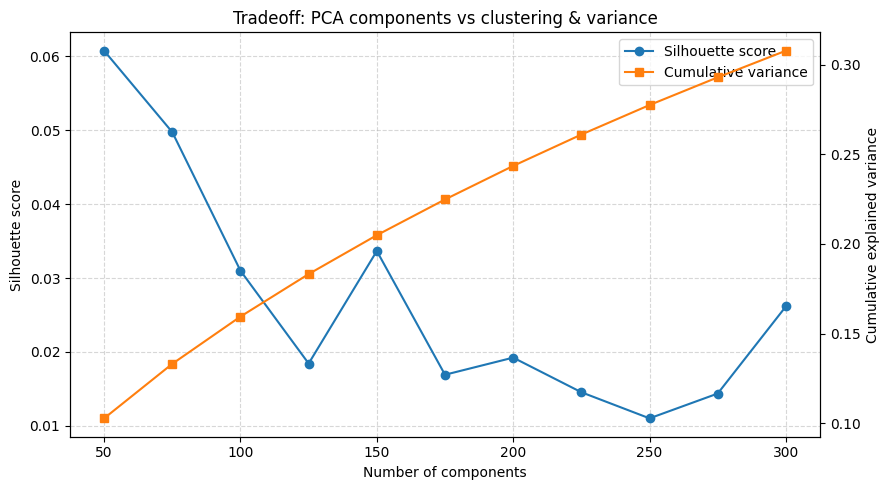

In [7]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt


components_to_test = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
n_clusters = 10
max_sil_samples = 5000   # subsample for silhouette to keep it fast

results = []

for n_comp in components_to_test:
    print(f"\n=== Testing {n_comp} components ===")

    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    X_red = svd.fit_transform(X_tfidf)

    cum_var = svd.explained_variance_ratio_.sum()
    print(f"Cumulative explained variance: {cum_var:.4f}")

    # K-means on reduced data
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = km.fit_predict(X_red)

    # Subsample for silhouette (it’s O(n^2))
    if X_red.shape[0] > max_sil_samples:
        idx = np.random.choice(X_red.shape[0], max_sil_samples, replace=False)
        sil = silhouette_score(X_red[idx], labels[idx])
    else:
        sil = silhouette_score(X_red, labels)

    print(f"Silhouette score: {sil:.4f}")

    results.append({
        "n_components": n_comp,
        "cum_explained_var": cum_var,
        "silhouette": sil
    })

results_df = pd.DataFrame(results)
display(results_df)

# plot the tradeoff
fig, ax1 = plt.subplots(figsize=(9,5))

ax1.plot(results_df["n_components"], results_df["silhouette"],
         marker="o", label="Silhouette score")
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Silhouette score")
ax1.grid(True, linestyle="--", alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(results_df["n_components"], results_df["cum_explained_var"],
         marker="s", color="tab:orange", label="Cumulative variance")
ax2.set_ylabel("Cumulative explained variance")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.title("Tradeoff: PCA components vs clustering & variance")
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/pca_ncomponent_tradeoff.png")
plt.show()


#### PCA Preprocess Pipeline

In [8]:
# PCA Feature Pipeline

# Check if PCA columns already exist and drop them so we don't get duplicates
cols_to_drop = [c for c in sampled_df.columns if c.startswith('pca_') or c == 'cluster']
sampled_df = sampled_df.drop(columns=cols_to_drop, errors='ignore')

from sklearn.decomposition import PCA

# Run PCA
OPTIMAL_N_COMPONENT = 50
# See above plot to find the optimal n_components
pca = PCA(n_components=OPTIMAL_N_COMPONENT)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Create a df from PCA results and attach it to sampled_df
pca_cols = [f"pca_{i}" for i in range(50)]
pca_df = pd.DataFrame(X_pca, columns=pca_cols)
sampled_df = pd.concat([sampled_df, pca_df], axis=1)

# Author and Venue Embeddings
# Venue embeddings
venue_emb = sampled_df.groupby("venue")[pca_cols].mean()

# Author embeddings
authors_exploded = []
authors_emb = []
authors_exploded = sampled_df.explode('authors')
author_emb = authors_exploded.groupby('authors')[pca_cols].mean()

#### Generate Interpretable Features
These are the metadata features for trend analysis and network analysis

In [9]:
# Number of Authors (Collaboration Size)
sampled_df['num_authors'] = sampled_df['authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Title Length (Character Count)
sampled_df['title_length'] = sampled_df['title'].apply(lambda x: len(str(x)))

# Number of References (How many papers this paper cites)
sampled_df['num_refs'] = sampled_df['references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Citation Velocity (Citations per year)
sampled_df['citation_velocity'] = sampled_df['n_citation'] / (2018 - sampled_df['year'].astype(int) + 1)
print(sampled_df['citation_velocity'].max())

# Change the types as well to reduce memory
as_type = {
    "num_authors": "category",
    "title_length": np.uint16,
    "num_refs": np.uint8,
    "citation_velocity": np.float32,
}

sampled_df[["title", 'year', 'num_authors', 'num_refs', 'citation_velocity']].head()

1231.875


,title,year,num_authors,num_refs,citation_velocity
0,correction to a note on the entscheidungsproblem,1936,1,1,1.807229
1,a system of formal logic without an analogue t...,1936,1,0,0.289157
2,finite combinatory processes--formulation 1,1936,1,0,4.421687
3,toward a calculus of concepts,1936,1,0,0.228916
4,a note on the entscheidungsproblem,1936,1,0,11.433735


### EDA Validation for our cleaned sampled dataset

To see if our preprocessing pipeline generated quality data

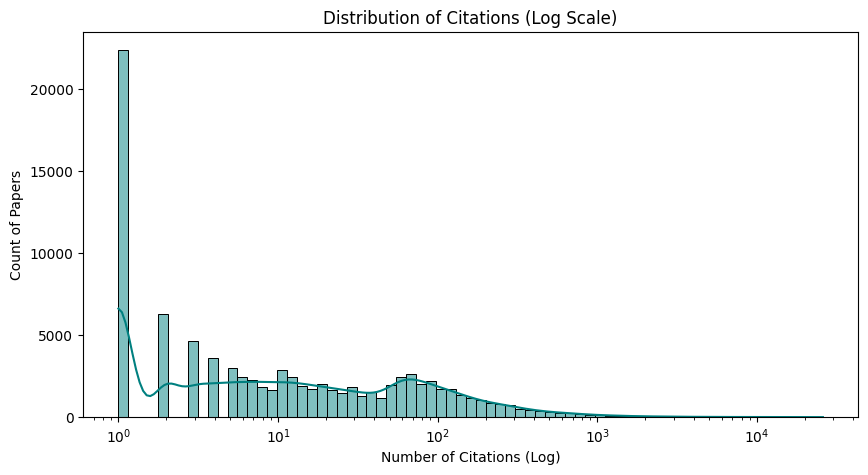

/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_39922/3985746004.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  auth_trend = sampled_df.groupby('year')['num_authors'].mean().reset_index()


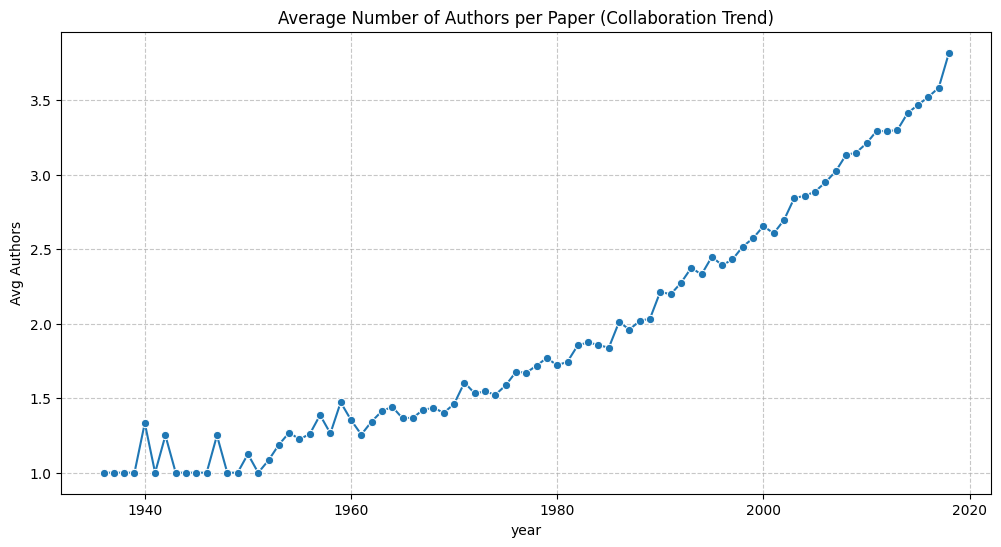

/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_39922/3985746004.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='venue', data=sampled_df[sampled_df['venue'].isin(top_venues)], order=top_venues, palette='viridis')


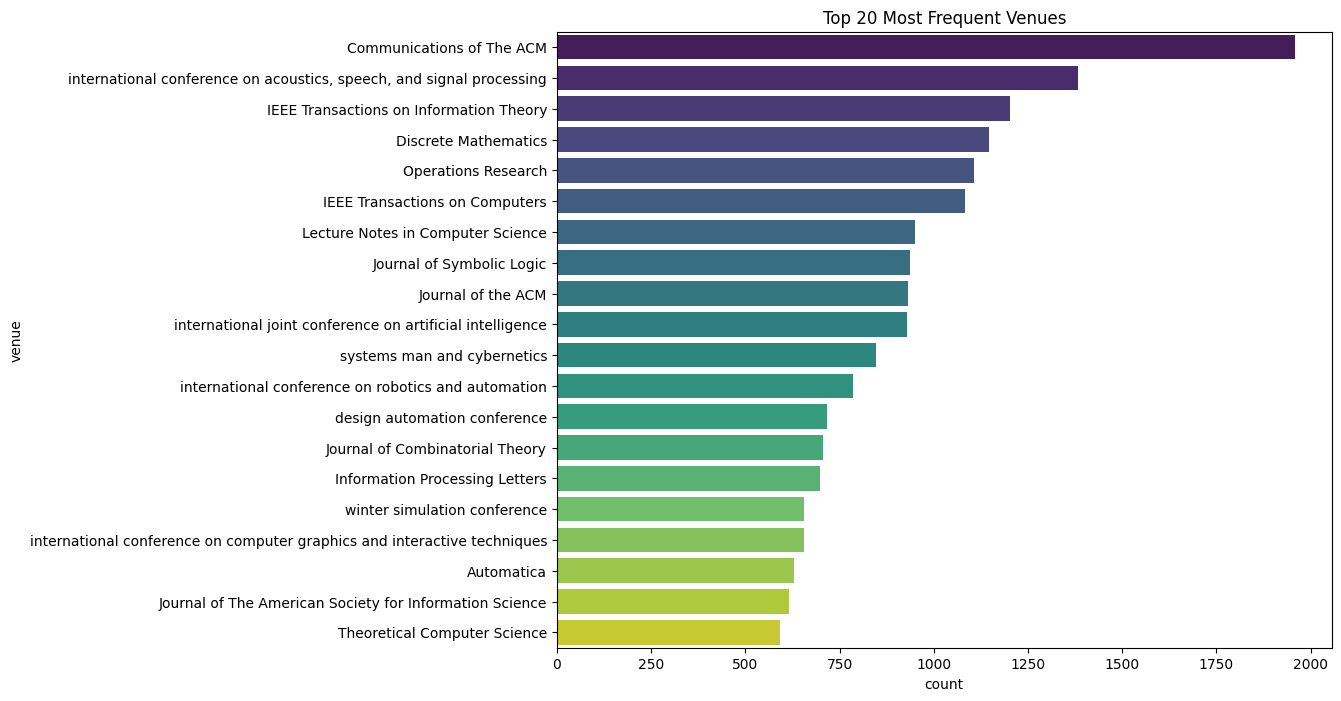

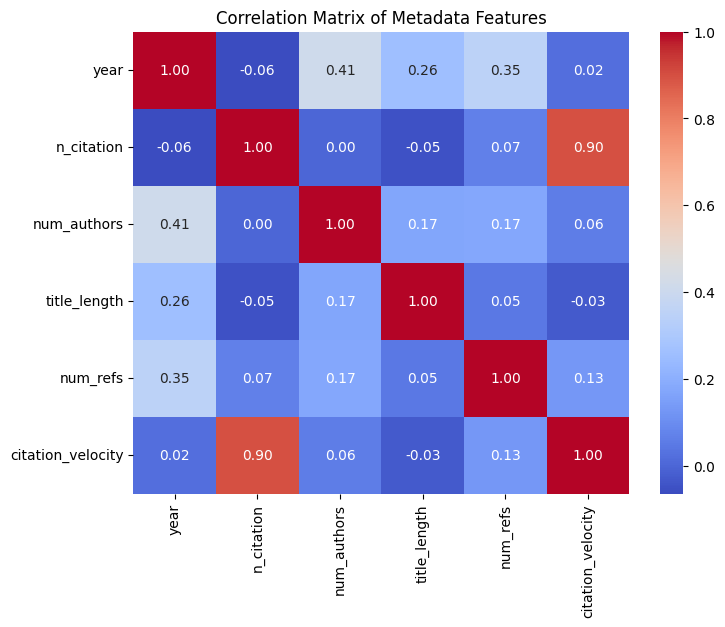

                       year  n_citation  num_authors  title_length  num_refs  \
year               1.000000   -0.064225     0.410631      0.258728  0.348519   
n_citation        -0.064225    1.000000     0.000011     -0.050928  0.066389   
num_authors        0.410631    0.000011     1.000000      0.171072  0.173306   
title_length       0.258728   -0.050928     0.171072      1.000000  0.045580   
num_refs           0.348519    0.066389     0.173306      0.045580  1.000000   
citation_velocity  0.022386    0.899824     0.056701     -0.030360  0.130627   

                   citation_velocity  
year                        0.022386  
n_citation                  0.899824  
num_authors                 0.056701  
title_length               -0.030360  
num_refs                    0.130627  
citation_velocity           1.000000  


In [10]:
# The "Power Law" Check (Citation Distribution)
# See https://link.springer.com/article/10.1007/s100510050359
# This is now done above in the preprocessing check
# Preprocessed above to remove n_citation = 50 outlier
# ARTIFACT_VAL = 50
# clean_df = sampled_df[sampled_df['n_citation'] != ARTIFACT_VAL]

plt.figure(figsize=(10,5))
sns.histplot(sampled_df['n_citation'] + 1, log_scale=True, kde=True, color='teal')
plt.title('Distribution of Citations (Log Scale)')
plt.xlabel('Number of Citations (Log)')
plt.ylabel('Count of Papers')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_citation_distribution.png")
plt.show()

plt.figure(figsize=(12, 6))
# Group by year and get mean authors
auth_trend = sampled_df.groupby('year')['num_authors'].mean().reset_index()
sns.lineplot(data=auth_trend, x='year', y='num_authors', marker='o')
plt.title('Average Number of Authors per Paper (Collaboration Trend)')
plt.ylabel('Avg Authors')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_collaboration_trend.png")
plt.show()

plt.figure(figsize=(10, 8))
# Get top 20 venues
top_venues = sampled_df['venue'].value_counts().nlargest(20).index
# Filter data to only those venues for plotting
sns.countplot(y='venue', data=sampled_df[sampled_df['venue'].isin(top_venues)], order=top_venues, palette='viridis')
plt.title('Top 20 Most Frequent Venues')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_top_venues.png")
plt.show()



# Select only numeric metadata
meta_cols = ['year', 'n_citation', 'num_authors', 'title_length', 'num_refs', 'citation_velocity']

plt.figure(figsize=(8, 6))
sns.heatmap(sampled_df[meta_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Metadata Features')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_corr_matrix.png")
plt.show()

print(sampled_df[meta_cols].corr())

## Task 2: Topic Clustering

#### K-Means Pipeline

Run clustering and name the topics

In [11]:
import numpy as np
from sklearn.cluster import KMeans

OPTIMAL_K = 8 # We chose this k for interpretability

# Fit Final Model
print(f"Clustering into {OPTIMAL_K} topics...")
# Use X_pca for the clustering itself (efficient)
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
sampled_df['cluster'] = kmeans.fit_predict(X_pca)

# Interpret Clusters (Keyword Extraction)
print("Extracting top keywords for each topic...")

# We need the original TF-IDF vocabulary to convert numbers back to words
feature_names = tfidf.get_feature_names_out()

# Group papers by cluster
for i in range(OPTIMAL_K):
    # Get the indices of papers in this cluster
    cluster_indices = sampled_df[sampled_df['cluster'] == i].index

    # Calculate the AVERAGE TF-IDF vector for this cluster
    # (We use the X_tfidf matrix from Task 1, slicing by the cluster's rows)
    cluster_center = X_tfidf[cluster_indices].mean(axis=0)

    # Convert matrix to 1D array
    cluster_center_arr = np.asarray(cluster_center).flatten()

    # Get indices of the top 10 highest weighted words
    top_indices = cluster_center_arr.argsort()[::-1][:10]

    # Map indices to words
    top_keywords = [feature_names[ind] for ind in top_indices]

    print(f"\n--- Cluster {i} ({len(cluster_indices)} papers) ---")
    print(f"Keywords: {', '.join(top_keywords)}")
    # Show a sample title to verify
    print(f"Sample Title: {sampled_df[sampled_df['cluster'] == i]['title'].iloc[0]}")

Clustering into 8 topics...
Extracting top keywords for each topic...

--- Cluster 0 (21524 papers) ---
Keywords: network, control, systems, model, design, based, performance, time, networks, paper
Sample Title: the model ii unityper

--- Cluster 1 (43047 papers) ---
Keywords: method, based, using, image, paper, logic, analysis, computer, theory, new
Sample Title: correction to a note on the entscheidungsproblem

--- Cluster 2 (3502 papers) ---
Keywords: information, systems, information systems, retrieval, information retrieval, user, based, research, knowledge, users
Sample Title: general treatment of the problem of coding

--- Cluster 3 (2454 papers) ---
Keywords: graph, graphs, vertices, vertex, edge, connected, number, edges, abstract, problem
Sample Title: regular expressions and state graphs for automata

--- Cluster 4 (661 papers) ---
Keywords: der, und, die, von, zur, ein, eine, mit, wird, das
Sample Title: nicht konstruktiv beweisbare satze der analysis

--- Cluster 5 (2052 p

For report:

Unsupervised clustering revealed a distinct group of non-english papers (cluster 1). We utilized this insight to filter the dataset, removing 186 foreign language documents to improve downstream topic modeling


Important: ONlY RUN THIS ONCE TO REMOVE THE GERMAN PAPERS!

Now we remove cluster x and rerun the pipeline

Re run TF-IDF -> PCA -> K-means pipeline

In [12]:
# Verify the german cluster index
sampled_df[sampled_df['cluster'] == 6]

,year,abstract,authors,n_citation,references,title,venue,id,text,pca_0,...,pca_45,pca_46,pca_47,pca_48,pca_49,num_authors,title_length,num_refs,citation_velocity,cluster
37,1943,,[J. C. C. McKinsey],67,[],the decision problem for some classes of sente...,Journal of Symbolic Logic,a51d4933-da3b-4c41-9937-cf0ddde36d00,the decision problem for some classes of sente...,0.071292,...,-0.073006,0.041819,0.010563,0.088711,-0.022138,1,70,0,0.881579,6
49,1947,,[Emil L. Post],124,[e254cbb5-e369-49dc-97a2-4d60eaea27dd],recursive unsolvability of a problem of thue,Journal of Symbolic Logic,4f665ce6-fb04-4bdb-a40c-cb221fc4d6db,recursive unsolvability of a problem of thue,0.119757,...,-0.014892,0.058060,-0.026264,-0.046248,0.027750,1,44,1,1.722222,6
111,1953,,[R. L. Goodstein],0,[],a problem in recursive function theory,Journal of Symbolic Logic,d9471b2c-a2f6-4cd4-9491-a72a8085f9d6,a problem in recursive function theory,0.129519,...,0.001519,0.062792,0.065107,-0.101499,0.002480,1,38,0,0.000000,6
136,1954,in the linear programming problem where there ...,"[Thomas L. Saaty, Saul I. Gass]",86,[],parametric objective function (part 1),Operations Research,3d0989d1-23f7-481b-92c1-5137e704e594,parametric objective function (part 1) in the ...,0.158465,...,0.002958,0.005419,0.048160,-0.079937,-0.040315,2,38,0,1.323077,6
148,1955,,[M. Lob],190,[],solution of a problem of leon henkin,Journal of Symbolic Logic,7d755e85-1d55-4838-9f79-fba6d8f80843,solution of a problem of leon henkin,0.111849,...,-0.004238,0.030414,-0.012471,-0.038622,-0.023897,1,36,0,2.968750,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91768,2017,we investigate the following version of the ma...,"[Ivan N. Landjev, Assia Rousseva]",0,"[0322f2f1-4f51-4650-a632-560a66b3dcf5, 2bb093d...",on the sharpness of the griesmer bound,Electronic Notes in Discrete Mathematics,ca344c34-8376-4fc4-8823-764e3c24011e,on the sharpness of the griesmer bound we inve...,0.144856,...,-0.001659,-0.055291,-0.078509,-0.048727,0.026434,2,38,2,0.000000,6
91770,2017,"in this paper, a nonconvex and nonsmooth metho...","[Zhuo-Xu Cui, Qibin Fan]",0,"[03a3965d-9785-48ba-bb32-922220678d20, 0717c3e...",a nonconvex nonsmooth regularization method fo...,Digital Signal Processing,7b0ef25d-6e99-4104-86e5-67315758ee22,a nonconvex nonsmooth regularization method fo...,0.104519,...,0.015995,-0.008360,-0.018041,0.003368,-0.005005,2,97,29,0.000000,6
91787,2017,hybrid manufacturing and remanufacturing syste...,"[Chang Fang, Xinbao Liu, Panos M. Pardalos, Ji...",0,"[0ab6d92b-44d2-44da-b029-39e138eb1216, 4dbd710...",a stochastic production planning problem in hy...,Journal of Global Optimization,26b8a5b2-0e30-40f2-a8b0-2f58fce32474,a stochastic production planning problem in hy...,0.030449,...,-0.030063,-0.008230,0.031400,-0.039210,0.020590,6,124,9,0.000000,6
91791,2017,"in plasma simulations, where the speed of ligh...","[Yingda Cheng, Andrew J. Christlieb, Wei Guo, ...",0,"[0f1e679f-65df-4a0e-90bc-310ee7506967, 1cfb246...",an asymptotic preserving maxwell solver result...,Journal of Scientific Computing,fa0e9757-6f64-4963-93a9-0deb0f9dfdda,an asymptotic preserving maxwell solver result...,0.074528,...,-0.006425,-0.020628,-0.009636,0.033995,0.032295,4,88,16,0.000000,6


In [13]:
german_cluster_id = 6
print(f"Removing {len(sampled_df[sampled_df['cluster'] == german_cluster_id])} non-English papers...")

sampled_df = sampled_df[sampled_df['cluster'] != german_cluster_id].copy()

sampled_df = sampled_df.reset_index(drop=True)

Removing 10801 non-English papers...


Visualize the clusters with new human-readable labels you might need to change the cluster_names list see above for the output result

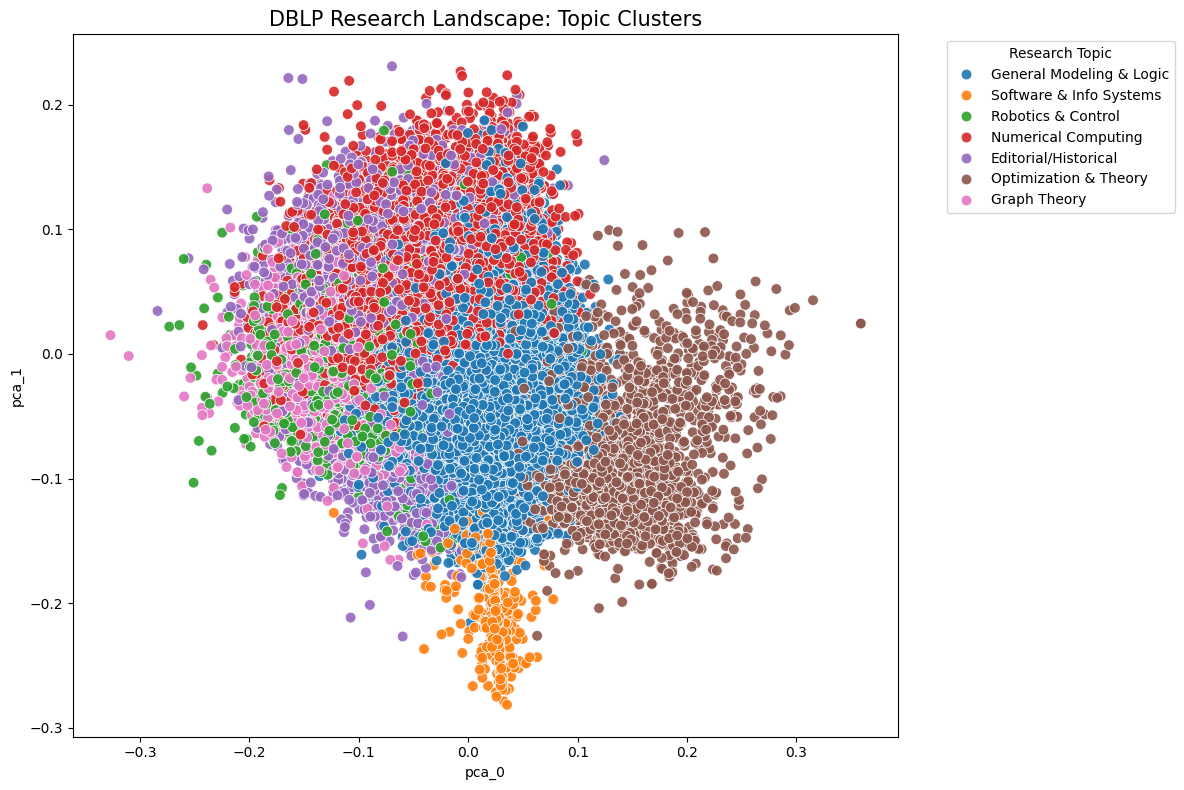

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Update cluster names based on the output we get above
cluster_names = {
    0: 'Numerical Computing',      # matrix, inversion, polynomial
    1: 'General Modeling & Logic', # (The large catch-all cluster)
    2: 'Robotics & Control',       # robot, controller, manipulator
    3: 'Optimization & Theory',    # linear programming, equations
    4: 'Software & Info Systems',  # language, software, user, design
    5: 'Graph Theory',             # vertices, edge, connected
    6: 'Networking & Wireless',    # wireless, routing, protocol
    7: 'Editorial/Historical'      # letters to editor, algol, acm
}

# Apply mapping
sampled_df['label'] = sampled_df['cluster'].map(cluster_names)

# 3. Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca_0',
    y='pca_1',
    hue='label',
    data=sampled_df,
    palette='tab10',
    alpha=0.9,
    s=60             # Marker size
)
plt.title('DBLP Research Landscape: Topic Clusters', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Research Topic')
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_pca.png")
plt.show()

In [15]:
from sklearn.manifold import TSNE

print("Running t-SNE to visualize clusters (this takes a moment)...")

# We use the same X_pca data, but project it differently
tsne = TSNE(n_components=2, verbose=1, perplexity=40, random_state=42)
tsne_results = tsne.fit_transform(X_pca)

# Add t-SNE results to the dataframe
sampled_df['tsne_x'] = tsne_results[:, 0]
sampled_df['tsne_y'] = tsne_results[:, 1]

# Plotting the t-SNE result
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_x',
    y='tsne_y',
    hue='label',
    data=sampled_df,
    palette='tab10', # Stronger colors
    alpha=0.7,
    s=40,
    legend='full'
)

plt.title('t-SNE Visualization of Research Topics', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_t-SNE.png")
plt.show()

Running t-SNE to visualize clusters (this takes a moment)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 91812 samples in 0.011s...
[t-SNE] Computed neighbors for 91812 samples in 4.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 91812
[t-SNE] Computed conditional probabilities for sample 2000 / 91812
[t-SNE] Computed conditional probabilities for sample 3000 / 91812
[t-SNE] Computed conditional probabilities for sample 4000 / 91812
[t-SNE] Computed conditional probabilities for sample 5000 / 91812
[t-SNE] Computed conditional probabilities for sample 6000 / 91812
[t-SNE] Computed conditional probabilities for sample 7000 / 91812
[t-SNE] Computed conditional probabilities for sample 8000 / 91812
[t-SNE] Computed conditional probabilities for sample 9000 / 91812
[t-SNE] Computed conditional probabilities for sample 10000 / 91812
[t-SNE] Computed conditional probabilities for sample 11000 / 91812
[t-SNE] Computed conditional probabilities for sample 12

KeyboardInterrupt: 

## Task 3: Temporal Trend Analysis

In [17]:
# use existing topic clusters to analyze citation trends over time
# build temporal trend data
trend = (
    sampled_df
    .groupby(['year', 'label'])
    .size()
    .rename('count')
    .reset_index()
)

/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_39922/1599574384.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['year', 'label'])


In [18]:
# normalize by year totals
year_totals = trend.groupby('year')['count'].sum().rename('year_total')
trend = trend.merge(year_totals, on='year')
trend["share"] = trend["count"] / trend["year_total"]

/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_39922/3402268545.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_totals = trend.groupby('year')['count'].sum().rename('year_total')


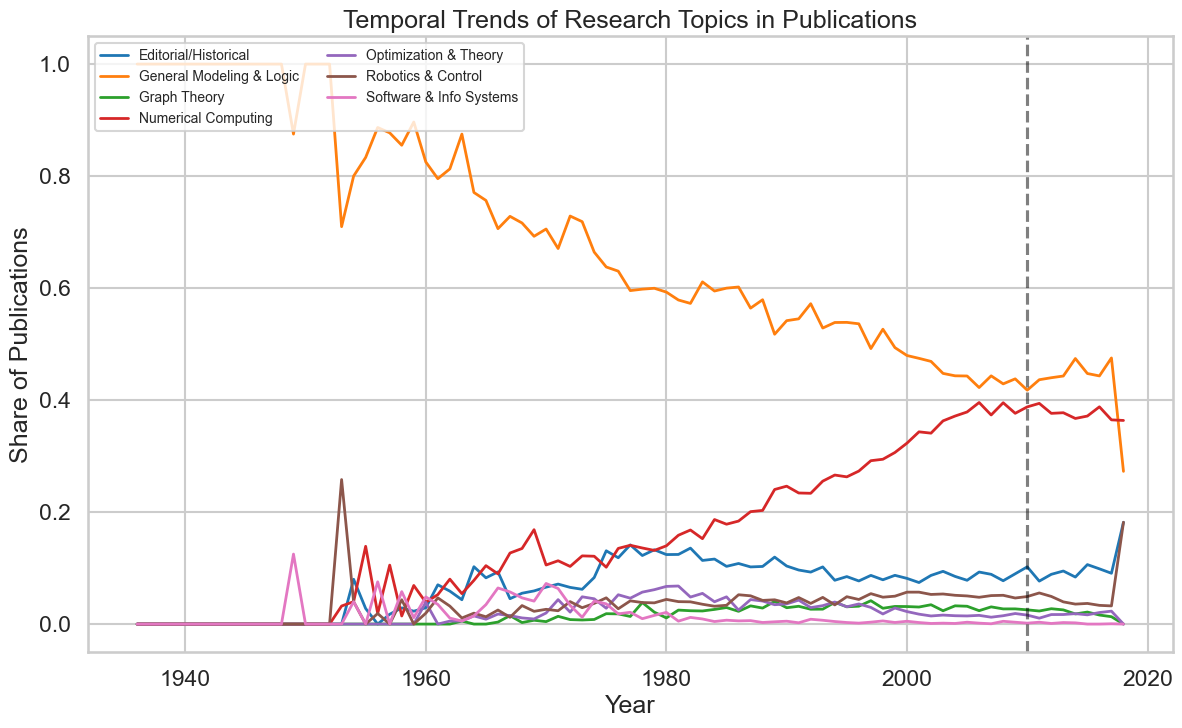

<Figure size 640x480 with 0 Axes>

In [20]:
# visualization of trends
sns.set(style="whitegrid", context="talk", palette="tab10")

plt.figure(figsize=(14, 8))
for label in trend['label'].unique():
    sub = trend[trend["label"] == label].sort_values("year")
    plt.plot(sub["year"], sub["share"], label=label, linewidth=2)

plt.axvline(2010, color="k", linestyle="--", alpha=0.5)
plt.title("Temporal Trends of Research Topics in Publications")
plt.xlabel("Year")
plt.ylabel("Share of Publications")
plt.legend(loc="upper left", ncol=2, fontsize=10, frameon=True)
plt.show()
plt.savefig(f"{FIGURE_SAVE_PATH}/temporal_trends.png")
plt.show()

In [21]:
# summary table for rise and fall of each topic over time
summary = (
    trend.assign(period=trend['year'].apply(lambda y: 'Pre-2010' if int(y) < 2010 else 'Post-2010'))
    .groupby(['label', 'period'])['share']
    .mean()
    .unstack()
    .reset_index()
)

print(summary)

period                     label  Post-2010  Pre-2010
0           Editorial/Historical   0.102665  0.063487
1       General Modeling & Logic   0.427745  0.710500
2                   Graph Theory   0.018942  0.014322
3            Numerical Computing   0.376735  0.144509
4          Optimization & Theory   0.015507  0.020368
5             Robotics & Control   0.057118  0.031420
6        Software & Info Systems   0.001288  0.015394


## Task 4: Predictive Modeling (Classification)

## Task 5: Network Analysis

In [5]:
df.columns

Index(['abstract', 'authors', 'n_citation', 'references', 'title', 'venue',
       'year', 'id'],
      dtype='object')

Importing graph libraries

In [8]:

import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import ast

plt.style.use("seaborn-v0_8")




Loading datasets

In [9]:
import json
import pandas as pd
import numpy as np

FILES = [
    "dblp-ref-0.json",
    "dblp-ref-1.json",
    "dblp-ref-2.json",
    "dblp-ref-3.json",
]

def read_json_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

def load_all(files=FILES):
    rows = []
    for fp in files:
        for rec in read_json_lines(f"./datasets/{fp}"):
            rows.append(rec)
    return pd.DataFrame(rows)

df = load_all()

as_type = {
    "year": "category",
    "n_citation": np.uint32,
}

df = df.astype(as_type)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079007 entries, 0 to 3079006
Data columns (total 8 columns):
 #   Column      Dtype   
---  ------      -----   
 0   abstract    object  
 1   authors     object  
 2   n_citation  uint32  
 3   references  object  
 4   title       object  
 5   venue       object  
 6   year        category
 7   id          object  
dtypes: category(1), object(6), uint32(1)
memory usage: 155.6+ MB


Cleaning & preparing necessary fields by turning them into Python lists

In [10]:
import ast

# Ensure authors are proper Python lists
df['authors'] = df['authors'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str)
    else (x if isinstance(x, list) else [])
)

# Ensure references are proper Python lists
df['references'] = df['references'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str)
    else (x if isinstance(x, list) else [])
)


Building the Co-Authorship Network

In [13]:
import ast

def safe_list_parse(v):
    if isinstance(v, list):
        return v
    if isinstance(v, str):
        try:
            parsed = ast.literal_eval(v)
            return parsed if isinstance(parsed, list) else []
        except:
            return []
    return []

df['authors'] = df['authors'].apply(safe_list_parse)
df['references'] = df['references'].apply(safe_list_parse)


Centrality Measures to identify key authors

In [14]:


deg = nx.degree_centrality(G_coauthor)

n_nodes = G_coauthor.number_of_nodes()
if n_nodes <= 200:
    # Small graph – compute exact betweenness
    bet = nx.betweenness_centrality(G_coauthor)
else:
    # Large graph – approximate with sampling
    bet = nx.betweenness_centrality(G_coauthor, k=200)

clos = nx.closeness_centrality(G_coauthor)

# Find top 10 authors
top_deg = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
top_bet = sorted(bet.items(), key=lambda x: x[1], reverse=True)[:10]
top_clos = sorted(clos.items(), key=lambda x: x[1], reverse=True)[:10]

top_deg, top_bet, top_clos




([], [], [])

Visualizing a Co-Authorship Ego Network

In [15]:

# to show key researchers & collaborators

if not top_deg:
    print("No authors in co-author graph (no co-authorships found in this sample).")
else:
    target_author = top_deg[0][0]  # highest-degree author
    ego = nx.ego_graph(G_coauthor, target_author, radius=1)

    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(ego, seed=42)
    nx.draw(
        ego, pos,
        node_size=80,
        node_color="skyblue",
        edge_color="gray",
        with_labels=False
    )
    plt.title(f"Ego Network of Author: {target_author}")
    plt.tight_layout()
    plt.savefig(f"{FIGURE_SAVE_PATH}/ego_network_{target_author}.png")
    plt.show()




No authors in co-author graph (no co-authorships found in this sample).


Prepare references & sample for citation network

In [16]:


# (authors/references already cleaned above, so we just sample)
sample_size = 20000  # adjust if needed
citation_df = df.sample(n=sample_size, random_state=42)

len(citation_df), citation_df.head(3)




(20000,
                                                   abstract authors  \
 683270   Abstract   Composite methods for compressing b...      []   
 1401401  One important step in regression analysis is t...      []   
 677311   Annual energy costs of streetlighting power us...      []   
 
          n_citation references  \
 683270           50         []   
 1401401           0         []   
 677311            0         []   
 
                                                      title  \
 683270   Compression of Binary Images by Composite Meth...   
 1401401  A link-free method for testing the significanc...   
 677311   A new approach to power consumption reduction ...   
 
                                                      venue  year  \
 683270   Journal of Visual Communication and Image Repr...  1995   
 1401401                   Journal of Multivariate Analysis  2011   
 677311                                                      2015   
 
                                

Building the Citation Network

In [17]:

# nodes = paper IDs, edges = A -> B if A cites B

G_citation = nx.DiGraph()

for _, row in citation_df.iterrows():
    src = row['id']
    refs = row['references']

    G_citation.add_node(src)

    for dst in refs:
        G_citation.add_edge(src, dst)

print("Citation graph nodes:", G_citation.number_of_nodes())
print("Citation graph edges:", G_citation.number_of_edges())




Citation graph nodes: 20000
Citation graph edges: 0


Citation Network Metrics

In [18]:


in_deg = G_citation.in_degree()
out_deg = G_citation.out_degree()

# Convert to sorted lists
top_cited_papers = sorted(in_deg, key=lambda x: x[1], reverse=True)[:10]
top_referencing = sorted(out_deg, key=lambda x: x[1], reverse=True)[:10]

top_cited_papers, top_referencing




([('00c892c5-a310-4ffe-9faf-03f5fbffb370', 0),
  ('a896b3da-65bc-40d1-ae17-c6388fa0640c', 0),
  ('ed51246f-d995-4355-b962-c365fc20217d', 0),
  ('1af201fc-6b8f-453e-b9a1-549ad13b52b4', 0),
  ('13f8d7a2-b01c-4b31-9606-48047e07e9b7', 0),
  ('8bbe10b8-cff4-4585-90c5-7f62aa0f953a', 0),
  ('e3ac73d3-b5f9-4bb4-b472-a2643c122070', 0),
  ('c7ccff02-1287-4b60-9856-73d341e00984', 0),
  ('c90da3c4-b8f5-4c7d-911d-56e9c1983e69', 0),
  ('eec71716-23aa-44db-aae3-fc7501a31490', 0)],
 [('00c892c5-a310-4ffe-9faf-03f5fbffb370', 0),
  ('a896b3da-65bc-40d1-ae17-c6388fa0640c', 0),
  ('ed51246f-d995-4355-b962-c365fc20217d', 0),
  ('1af201fc-6b8f-453e-b9a1-549ad13b52b4', 0),
  ('13f8d7a2-b01c-4b31-9606-48047e07e9b7', 0),
  ('8bbe10b8-cff4-4585-90c5-7f62aa0f953a', 0),
  ('e3ac73d3-b5f9-4bb4-b472-a2643c122070', 0),
  ('c7ccff02-1287-4b60-9856-73d341e00984', 0),
  ('c90da3c4-b8f5-4c7d-911d-56e9c1983e69', 0),
  ('eec71716-23aa-44db-aae3-fc7501a31490', 0)])

Plotting the Citation Degree Distribution

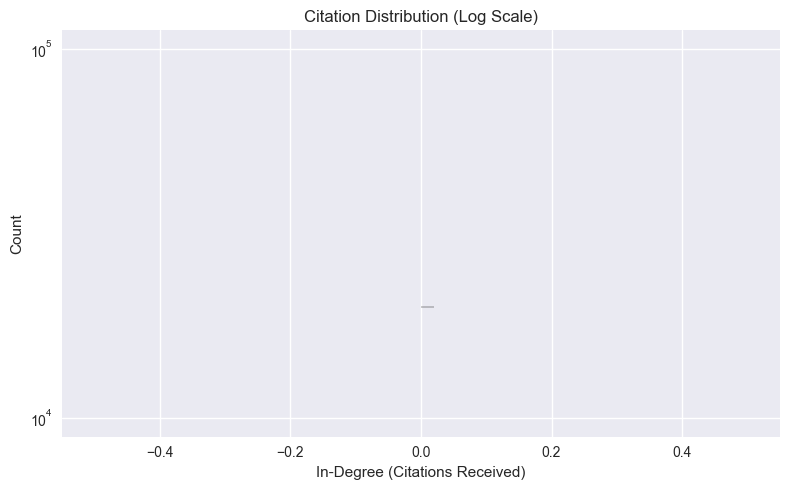

In [19]:

degrees = [d for _, d in G_citation.in_degree()]

plt.figure(figsize=(8, 5))
sns.histplot(degrees, bins=50, log_scale=(False, True))
plt.xlabel("In-Degree (Citations Received)")
plt.ylabel("Count")
plt.title("Citation Distribution (Log Scale)")
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/citation_distribution.png")
plt.show()
